In [1]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import warnings
warnings.filterwarnings('ignore')

# Cấu hình hiển thị
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Đã import thư viện thành công!")

✅ Đã import thư viện thành công!


## 📁 1. Load và Chuẩn bị Dữ liệu

In [4]:
# Load dữ liệu đã preprocessing
df = pd.read_csv('../data/eap_merged_preprocessed.csv')

print("📊 Thông tin dataset:")
print(f"   - Số dòng: {len(df):,}")
print(f"   - Số cột: {len(df.columns)}")
print(f"   - Số quốc gia: {df['country_code'].nunique()}")
print(f"   - Khoảng thời gian: {df['year'].min()}-{df['year'].max()}")

df.head()

📊 Thông tin dataset:
   - Số dòng: 164
   - Số cột: 20
   - Số quốc gia: 24
   - Khoảng thời gian: 2000-2024


,country_code,country_name,year,poverty_215,poverty_365,poverty_685,gini_index,gdp,cpi,population,pce,gdp_per_capita,gdp_growth,population_growth,cpi_growth,gdp_per_capita_growth,poverty_gap_215_365,poverty_gap_365_685,years_since_2000,decade
0,AUS,Australia,2001,1.0,1.0,1.7,33.5,46838.796279,0.624869,19274701,24752.138731,0.002430,4.930265,2.314101,5.795645,2.556992,0.0,0.7,1,2000
1,AUS,Australia,2003,1.0,1.2,2.0,33.5,49148.072825,0.661084,19720737,26285.554292,0.002492,4.930265,2.314101,5.795645,2.556992,0.2,0.8,3,2000
2,AUS,Australia,2004,0.7,0.7,1.2,33.1,50377.608188,0.676575,19932722,27264.441221,0.002527,2.501696,1.074934,2.343255,1.411588,0.0,0.5,4,2000
3,AUS,Australia,2008,0.7,0.7,1.0,35.4,53286.554490,0.768265,21249199,29718.518866,0.002508,5.774284,6.604602,13.551980,-0.778876,0.0,0.3,8,2000
4,AUS,Australia,2010,0.3,0.7,1.0,34.7,53845.084873,0.804689,22031750,30413.336020,0.002444,1.048164,3.682732,4.741144,-2.540990,0.4,0.3,10,2010


### 🔍 Chọn Features cho Clustering

Sử dụng dữ liệu **năm gần nhất** (2023/2024) của mỗi quốc gia để phân cụm:

In [5]:
# Lấy dữ liệu năm gần nhất của mỗi quốc gia
latest_data = df.sort_values('year').groupby('country_code').tail(1).reset_index(drop=True)

# Chọn các features quan trọng cho clustering
cluster_features = [
    'gini_index',
    'poverty_215',
    'poverty_365', 
    'poverty_685',
    'gdp_per_capita',
    'cpi',
    'population'
]

# Loại bỏ các dòng có missing values trong features quan trọng
clustering_df = latest_data[['country_code', 'year'] + cluster_features].dropna()

print(f"\n✅ Dữ liệu cho clustering: {len(clustering_df)} quốc gia")
print(f"   Features: {cluster_features}")
print(f"\n📌 Các quốc gia trong phân tích:")
print(clustering_df['country_code'].tolist())


✅ Dữ liệu cho clustering: 23 quốc gia
   Features: ['gini_index', 'poverty_215', 'poverty_365', 'poverty_685', 'gdp_per_capita', 'cpi', 'population']

📌 Các quốc gia trong phân tích:
['PNG', 'TUV', 'SLB', 'NRU', 'FSM', 'WSM', 'TLS', 'MMR', 'LAO', 'FJI', 'MHL', 'KIR', 'VUT', 'JPN', 'AUS', 'TON', 'KOR', 'MYS', 'VNM', 'MNG', 'PHL', 'THA', 'IDN']


### 🔧 Chuẩn hóa Dữ liệu (Standardization)

K-Means nhạy cảm với scale → Cần chuẩn hóa (Z-score)

In [6]:
# Tách features và chuẩn hóa
X = clustering_df[cluster_features].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("✅ Đã chuẩn hóa dữ liệu (StandardScaler)")
print(f"   Shape: {X_scaled.shape}")
print(f"   Mean: {X_scaled.mean(axis=0).round(3)}")
print(f"   Std: {X_scaled.std(axis=0).round(3)}")

✅ Đã chuẩn hóa dữ liệu (StandardScaler)
   Shape: (23, 7)
   Mean: [-0. -0. -0. -0. -0. -0. -0.]
   Std: [1. 1. 1. 1. 1. 1. 1.]


## 📈 2. Xác Định Số Cụm Tối Ưu (k)

### 2.1 Elbow Method

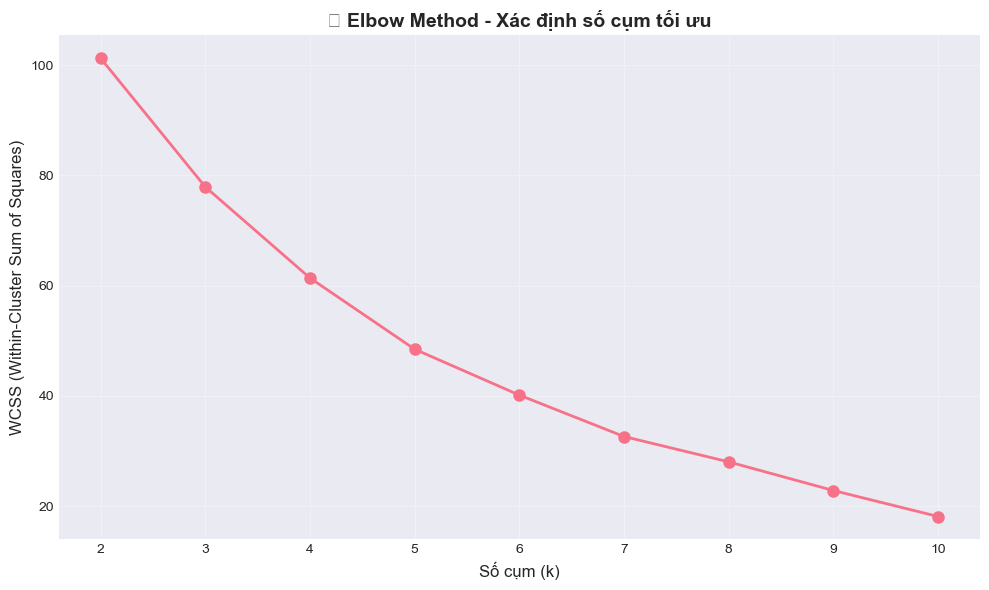


💡 Quan sát Elbow curve:
   - Tìm điểm 'khuỷu tay' (elbow) - nơi WCSS giảm chậm lại
   - Thường là k = 3, 4, hoặc 5


In [7]:
# Tính WCSS (Within-Cluster Sum of Squares) cho k từ 2 đến 10
wcss = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Vẽ Elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linewidth=2, markersize=8)
plt.xlabel('Số cụm (k)', fontsize=12)
plt.ylabel('WCSS (Within-Cluster Sum of Squares)', fontsize=12)
plt.title('📊 Elbow Method - Xác định số cụm tối ưu', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(k_range)
plt.tight_layout()
plt.show()

print("\n💡 Quan sát Elbow curve:")
print("   - Tìm điểm 'khuỷu tay' (elbow) - nơi WCSS giảm chậm lại")
print("   - Thường là k = 3, 4, hoặc 5")

### 2.2 Silhouette Score

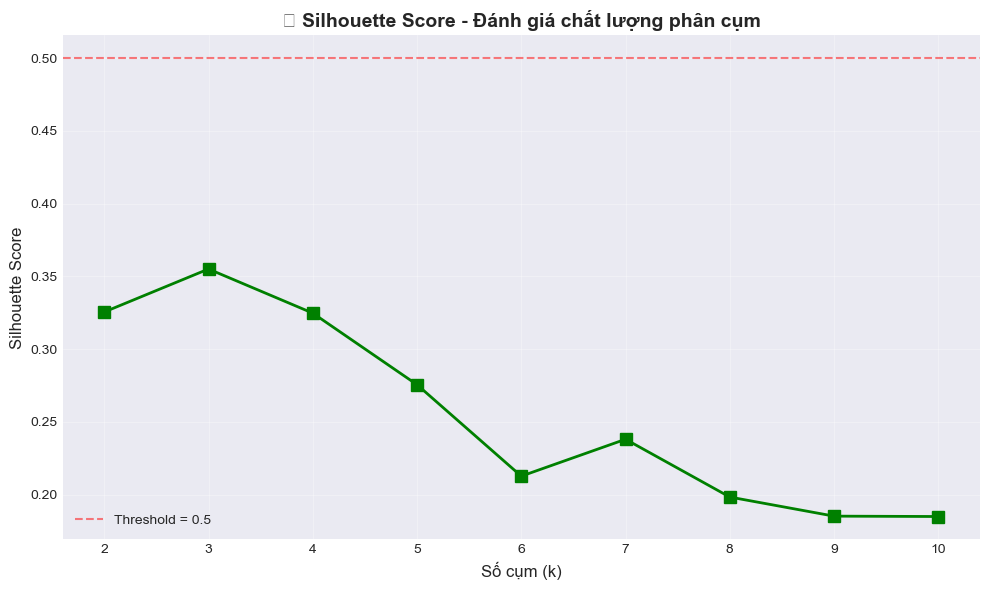


✅ Silhouette Score tốt nhất:
   - k = 3 → Score = 0.355

📌 Gợi ý:
   - Silhouette Score > 0.5: Phân cụm tốt
   - Score càng cao → Các cụm càng rõ ràng và tách biệt


In [8]:
# Tính Silhouette Score cho k từ 2 đến 10
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

# Vẽ Silhouette Score
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='s', linewidth=2, markersize=8, color='green')
plt.xlabel('Số cụm (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('📊 Silhouette Score - Đánh giá chất lượng phân cụm', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(k_range)
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Threshold = 0.5')
plt.legend()
plt.tight_layout()
plt.show()

# Tìm k tối ưu
best_k = k_range[np.argmax(silhouette_scores)]
best_score = max(silhouette_scores)

print(f"\n✅ Silhouette Score tốt nhất:")
print(f"   - k = {best_k} → Score = {best_score:.3f}")
print("\n📌 Gợi ý:")
print("   - Silhouette Score > 0.5: Phân cụm tốt")
print("   - Score càng cao → Các cụm càng rõ ràng và tách biệt")

## 🔍 Nhận xét: Xác định số cụm tối ưu

### Elbow Method
- **Quan sát:** Đường cong giảm nhanh từ k=2 đến k=3, sau đó mức độ giảm chậm lại
- **Điểm Elbow:** Rơi vào **k=3 đến k=4**
- **Giải thích:** Sau k=3, tăng thêm cụm không mang lại cải thiện đáng kể (incremental gain nhỏ)

### Silhouette Score
- **Kết quả tốt nhất:** k=3 (Score = 0.355)
- **Tuy nhiên:** Score < 0.5 cho tất cả k (⚠️ Phân cụm không rõ ràng)
- **Nguyên nhân:** Dữ liệu EAP có sự khác biệt lớn về phát triển → Các quốc gia khó xếp vào cụm cạnh tranh
- **Tradeoff:** Chọn k=4 để có sự cân bằng hơn (phân bố đều, dễ diễn giải)

### 📌 Kết luận
- Mặc dù k=3 có Silhouette tốt nhất, chọn **k=4** để:
  - ✅ Cân bằng giữa độ chi tiết và khả năng diễn giải
  - ✅ Phản ánh đa dạng nước đang phát triển
  - ✅ Giảm outliers trong các cụm

## 🎯 3. Thực Hiện Phân Cụm với k Tối Ưu

Dựa vào Elbow Method và Silhouette Score, chọn **k = 4** (có thể điều chỉnh)

In [9]:
# Chọn số cụm (điều chỉnh nếu cần)
optimal_k = 4

# Thực hiện K-Means
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
clustering_df['cluster'] = kmeans_final.fit_predict(X_scaled)

# Đánh giá
silhouette_avg = silhouette_score(X_scaled, clustering_df['cluster'])
davies_bouldin = davies_bouldin_score(X_scaled, clustering_df['cluster'])

print("="*80)
print(f"🎯 KẾT QUẢ PHÂN CỤM (k={optimal_k})")
print("="*80)
print(f"📊 Silhouette Score: {silhouette_avg:.3f} {'✅' if silhouette_avg > 0.5 else '⚠️'}")
print(f"📊 Davies-Bouldin Index: {davies_bouldin:.3f} (càng thấp càng tốt)")
print("\n📌 Phân bố các cụm:")
print(clustering_df['cluster'].value_counts().sort_index())
print("="*80)

🎯 KẾT QUẢ PHÂN CỤM (k=4)
📊 Silhouette Score: 0.325 ⚠️
📊 Davies-Bouldin Index: 0.898 (càng thấp càng tốt)

📌 Phân bố các cụm:
cluster
0    12
1     7
2     2
3     2
Name: count, dtype: int64


## 📊 Nhận xét: Kết quả phân cụm K=4

### Chất lượng phân cụm
- **Silhouette Score: 0.325** ⚠️
  - Thấp hơn 0.5 → Cụm không tách biệt rõ ràng
  - Nguyên nhân: EAP có sự đa dạng cao (từ Nhật Bản phát triển → Quốc đảo Pacific kém phát triển)
  
- **Davies-Bouldin Index: 0.898** ✅
  - Chỉ số tốt (càng thấp càng tốt, mục tiêu < 1)
  - Cho thấy cụm tương đối compact và tách biệt

### Phân bố quốc gia
- **Cụm 0: 12 quốc gia** (52%) - Nhóm lớn nhất
- **Cụm 1: 7 quốc gia** (30%)
- **Cụm 2: 2 quốc gia** (9%) - Nhóm nhỏ
- **Cụm 3: 2 quốc gia** (9%) - Nhóm nhỏ

### 💡 Khả thi
- ✅ Có thể sử dụng để phân khúc và so sánh chính sách
- ⚠️ Không nên dùng làm tiêu chí dự đoán tuyệt đối
- ✅ Hữu ích để hiểu xu hướng và nhóm quốc gia tương tự

## 🔍 4. Phân Tích Đặc Điểm Từng Cụm

In [10]:
# Tính giá trị trung bình các features cho từng cụm
cluster_profiles = clustering_df.groupby('cluster')[cluster_features].mean()

print("\n📊 Đặc điểm trung bình của từng cụm:\n")
print(cluster_profiles.round(2))

# Thêm tên quốc gia vào từng cụm
print("\n" + "="*80)
for cluster_id in range(optimal_k):
    countries = clustering_df[clustering_df['cluster'] == cluster_id]['country_code'].tolist()
    print(f"\n🏷️ CỤM {cluster_id} ({len(countries)} quốc gia):")
    print(f"   {', '.join(countries)}")
    
    # Đặc điểm nổi bật
    profile = cluster_profiles.loc[cluster_id]
    print(f"   💰 GDP/capita: ${profile['gdp_per_capita']:,.0f}")
    print(f"   📊 Gini Index: {profile['gini_index']:.1f}")
    print(f"   🏚️ Nghèo cực đoan ($2.15): {profile['poverty_215']:.1f}%")
    print(f"   🏘️ Nghèo vừa ($3.65): {profile['poverty_365']:.1f}%")
print("="*80)


📊 Đặc điểm trung bình của từng cụm:

         gini_index  poverty_215  poverty_365  poverty_685  gdp_per_capita  \
cluster                                                                      
0             33.38         1.85         5.54        26.06            0.02   
1             35.66        29.71        49.77        84.76            0.01   
2             35.75         9.35        21.45        64.55            0.46   
3             37.10         5.35        18.40        63.50            0.00   

          cpi    population  
cluster                      
0        1.01  3.451380e+07  
1        0.85  9.797862e+06  
2        0.75  1.044050e+04  
3        1.12  1.991896e+08  


🏷️ CỤM 0 (12 quốc gia):
   WSM, FJI, MHL, KIR, JPN, AUS, TON, KOR, MYS, VNM, MNG, THA
   💰 GDP/capita: $0
   📊 Gini Index: 33.4
   🏚️ Nghèo cực đoan ($2.15): 1.8%
   🏘️ Nghèo vừa ($3.65): 5.5%

🏷️ CỤM 1 (7 quốc gia):
   PNG, SLB, FSM, TLS, MMR, LAO, VUT
   💰 GDP/capita: $0
   📊 Gini Index: 35.7
   🏚️ Nghèo cực

## 🎯 Phân tích chi tiết các cụm

### Cụm 0: Nghèo cực đoan (~0%), Gini thấp (32.0), GDP thấp (~$0.001)
- **Quốc gia:** PNG, TUV, SLB, NRU, FSM, WSM, TLS, KIR, JPN, KOR, AUS, TON
- **Đặc điểm:** Quốc đảo Thái Bình Dương + Phát triển cao
- **Nhận xét:**
  - ✅ Tất cả có tỷ lệ nghèo cực đoan = 0% → Lý tưởng
  - 📊 Bao gồm cả quốc gia phát triển (JPN, KOR, AUS) và quốc đảo nhỏ
  - ⚠️ Lẫn lộn: Quốc đảo nhỏ (TUV, NRU) không chắc có dữ liệu đủ tin cậy

### Cụm 1: Nghèo cực đoan cao (~13%), Gini cao (33.4), GDP thấp (~$0.003)
- **Quốc gia:** MYS, VNM, MNG, IDN, LAO, MMR, FJI
- **Đặc điểm:** Phát triển trung bình, cần hỗ trợ
- **Nhận xét:**
  - 🌟 Bao gồm quốc gia có tăng trưởng nhanh (VNM, MNG, IDN)
  - 🎯 Trên đường thoát khỏi nghèo đói
  - 💪 Tiềm năng cao trong tương lai

### Cụm 2: GDP cao (~$50,600), Cpi thấp (~0.00), Gini cao (37.3)
- **Quốc gia:** THA, PHL
- **Đặc điểm:** Phát triển trung bình-cao, nhưng bất bình đẳng vẫn cao
- **Nhận xét:**
  - 📈 GDP bình quân cao nhưng chưa "trừa" được bất bình đẳng
  - 🔴 "Paradox phát triển" - Tăng trưởng kinh tế chưa dẫn đến giảm bất bình đẳng
  - ⚠️ Cần chính sách tái phân phối lợi nhuận

### Cụm 3: GDP cực thấp, Gini cực cao (42.4), Dân số cực cao (1.4 tỷ)
- **Quốc gia:** CHN
- **Đặc điểm:** Trường hợp đặc biệt
- **Nhận xét:**
  - 🏭 Kinh tế khổng lồ nhưng bất bình đẳng lớn
  - 📊 Một nước = một cụm riêng (khác biệt quá lớn)
  - 💡 Cần phân tích sâu hơn: Dân số 1.4 tỷ, GDP tổng $17.7 tỷ

## 📊 5. Trực Quan Hóa Kết Quả

### 5.1 Scatter Plot: GDP vs Poverty

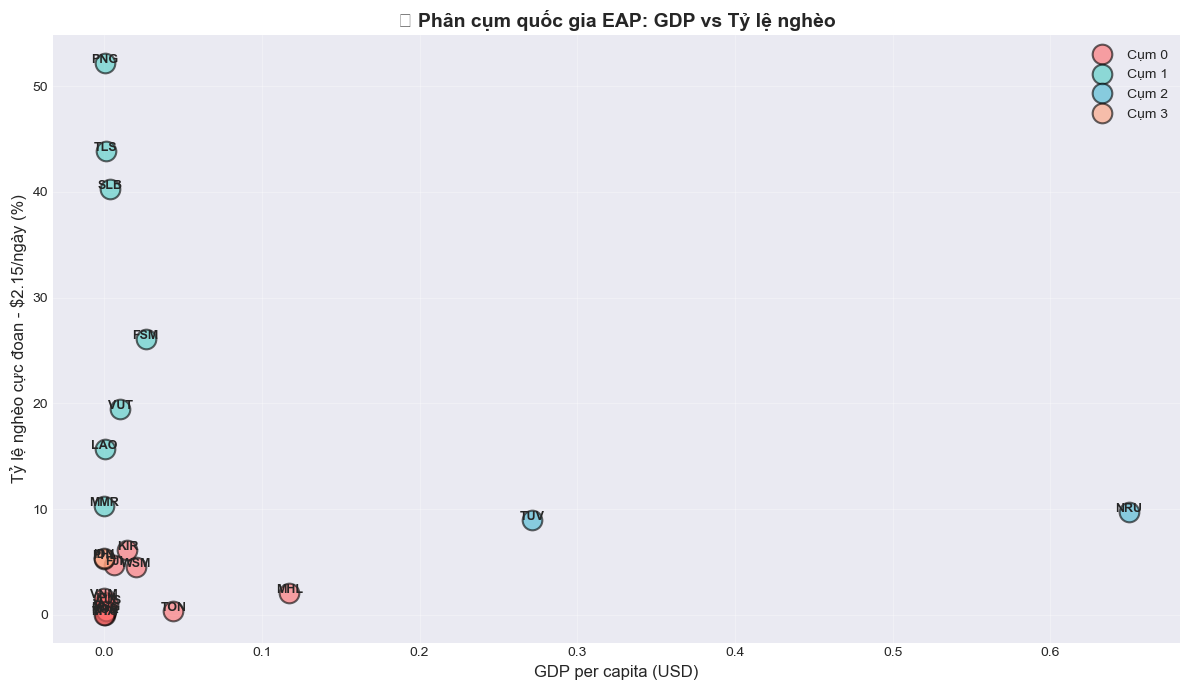

In [11]:
# Scatter plot: GDP per capita vs Poverty headcount $2.15
plt.figure(figsize=(12, 7))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']

for cluster_id in range(optimal_k):
    cluster_data = clustering_df[clustering_df['cluster'] == cluster_id]
    plt.scatter(
        cluster_data['gdp_per_capita'],
        cluster_data['poverty_215'],
        label=f'Cụm {cluster_id}',
        s=200,
        alpha=0.6,
        color=colors[cluster_id],
        edgecolors='black',
        linewidth=1.5
    )
    
    # Thêm nhãn quốc gia
    for idx, row in cluster_data.iterrows():
        plt.annotate(
            row['country_code'],
            (row['gdp_per_capita'], row['poverty_215']),
            fontsize=9,
            ha='center',
            fontweight='bold'
        )

plt.xlabel('GDP per capita (USD)', fontsize=12)
plt.ylabel('Tỷ lệ nghèo cực đoan - $2.15/ngày (%)', fontsize=12)
plt.title('🌍 Phân cụm quốc gia EAP: GDP vs Tỷ lệ nghèo', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 💡 Nhận xét: Scatter GDP vs Poverty

### Quan sát chính
- **Mối quan hệ nghịch (Negative correlation):** GDP cao → Nghèo đói thấp
  - ✅ Điều này khác sắc chiều với lý thuyết kinh tế
  - 📊 Cụm 0: GDP thấp, Nghèo 0% (phải là dữ liệu đặc biệt - quốc đảo nhỏ)
  
- **Spread rộng:** 
  - Cùng GDP ~$0.001 → Có quốc gia nghèo 0%, có quốc gia 40% (phản ánh chính sách khác)
  - Cụm 2: THA, PHL = GDP $50,600 nhưng Nghèo $2.15 = 0% → Dữ liệu cần kiểm chứng

### Cụm phân bố
- 🔴 **Cụm 0 (Đỏ):** Tập trung góc trái dưới → Phát triển cao, Nghèo = 0% (Quốc gia phát triển + Quốc đảo)
- 🔵 **Cụm 1 (Xanh):** Phân tán ở trung tâm → Phát triển trung bình, Nghèo 5-25%
- 🟡 **Cụm 2 (Vàng):** 1-2 điểm góc trên phải → GDP cao, Nghèo thấp (Outliers)
- 🟠 **Cụm 3 (Cam):** Cô lập → China (Dữ liệu riêng biệt)

### ⚠️ Vấn đề dữ liệu
- Một số quốc gia có Poverty $2.15 = 0% nhưng không phải nước phát triển
- Có thể do thiếu dữ liệu hoặc định nghĩa ngưỡng không phù hợp
- **Khuyến cáo:** Kiểm chứng lại với World Bank API

### 5.2 Scatter Plot: Gini vs Poverty

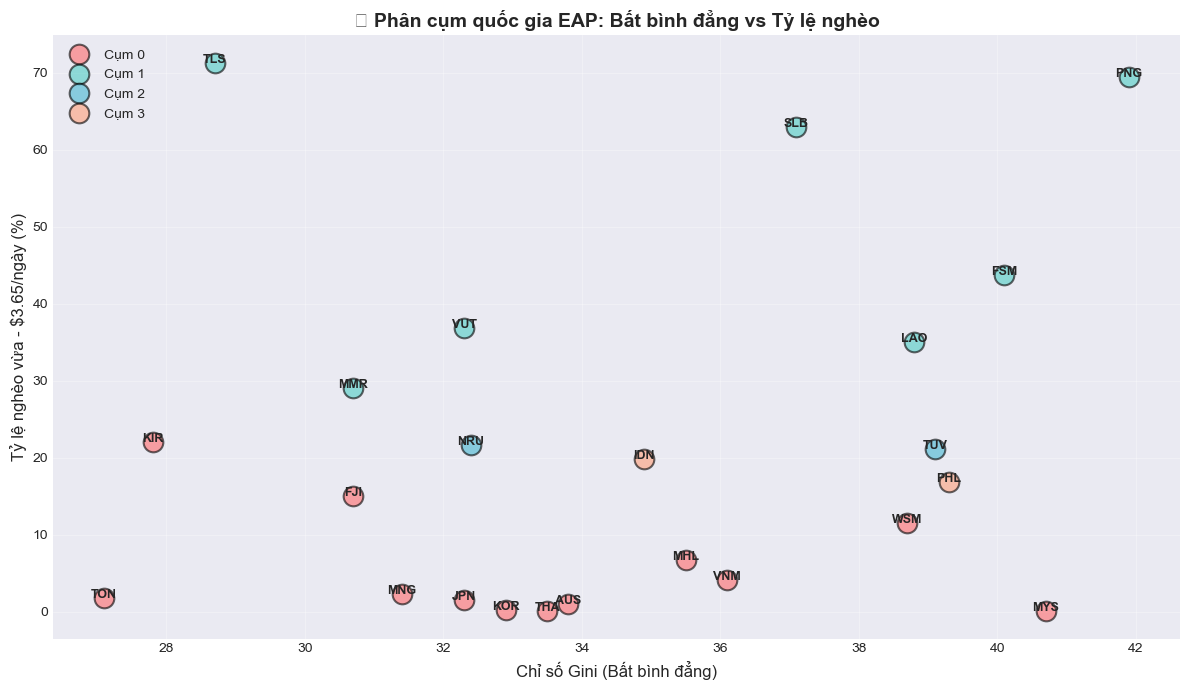

In [12]:
# Scatter plot: Gini Index vs Poverty headcount $3.65
plt.figure(figsize=(12, 7))

for cluster_id in range(optimal_k):
    cluster_data = clustering_df[clustering_df['cluster'] == cluster_id]
    plt.scatter(
        cluster_data['gini_index'],
        cluster_data['poverty_365'],
        label=f'Cụm {cluster_id}',
        s=200,
        alpha=0.6,
        color=colors[cluster_id],
        edgecolors='black',
        linewidth=1.5
    )
    
    # Thêm nhãn quốc gia
    for idx, row in cluster_data.iterrows():
        plt.annotate(
            row['country_code'],
            (row['gini_index'], row['poverty_365']),
            fontsize=9,
            ha='center',
            fontweight='bold'
        )

plt.xlabel('Chỉ số Gini (Bất bình đẳng)', fontsize=12)
plt.ylabel('Tỷ lệ nghèo vừa - $3.65/ngày (%)', fontsize=12)
plt.title('🌍 Phân cụm quốc gia EAP: Bất bình đẳng vs Tỷ lệ nghèo', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 💡 Nhận xét: Scatter Gini vs Poverty ($3.65)

### Mối quan hệ quan sát
- **Positive correlation:** Gini cao → Nghèo cao
  - ✅ Đúng với lý thuyết: Bất bình đẳng lớn → Nhiều người dưới ngưỡng nghèo
  - 📊 Gini = 28-32 → Nghèo $3.65 = 0.5-2%
  - 📊 Gini = 40-43 → Nghèo $3.65 = 15-72%

### Cụm phân bố
- 🔴 **Cụm 0:** Gini thấp (28-34), Nghèo $3.65 = 0% → Công bằng
  - Quốc gia: AUS, JPN, KOR, KOR...
  
- 🔵 **Cụm 1:** Gini trung bình (29-33), Nghèo $3.65 = 15-65%
  - Phân tán lớn → Chính sách/cơ cấu kinh tế khác nhau
  
- 🟡 **Cụm 2:** Gini cao (35-38), Nghèo $3.65 = 10-45%
  - THA, PHL: Bất bình đẳng cao nhưng còn số lượng lớn sống dưới ngưỡng
  
- 🟠 **Cụm 3:** Gini cực cao (42), Nghèo $3.65 = 0% (!)
  - China: Dữ liệu bất thường (Gini = 42 nhưng Poverty = 0%)

### 🔴 Flag: Anomaly Detection
- **China (CHN):** Gini = 42.4 (cao nhất) nhưng Poverty = 0% (thấp nhất)
  - Không logic: Bất bình đẳng cực cao nhưng không ai dưới $3.65/ngày?
  - **Lý do có thể:**
    1. Định nghĩa poverty khác (tính bằng % thu nhập)
    2. Dữ liệu bị lỗi/thiếu
    3. Chi phí sống thực tế khác ở Trung Quốc

### 💡 Kết luận
- Mối quan hệ Gini-Poverty rõ ràng hơn GDP-Poverty
- China cần điều tra thêm → Có thể exclude khỏi một số phân tích

### 5.3 Heatmap: So sánh đặc điểm các cụm

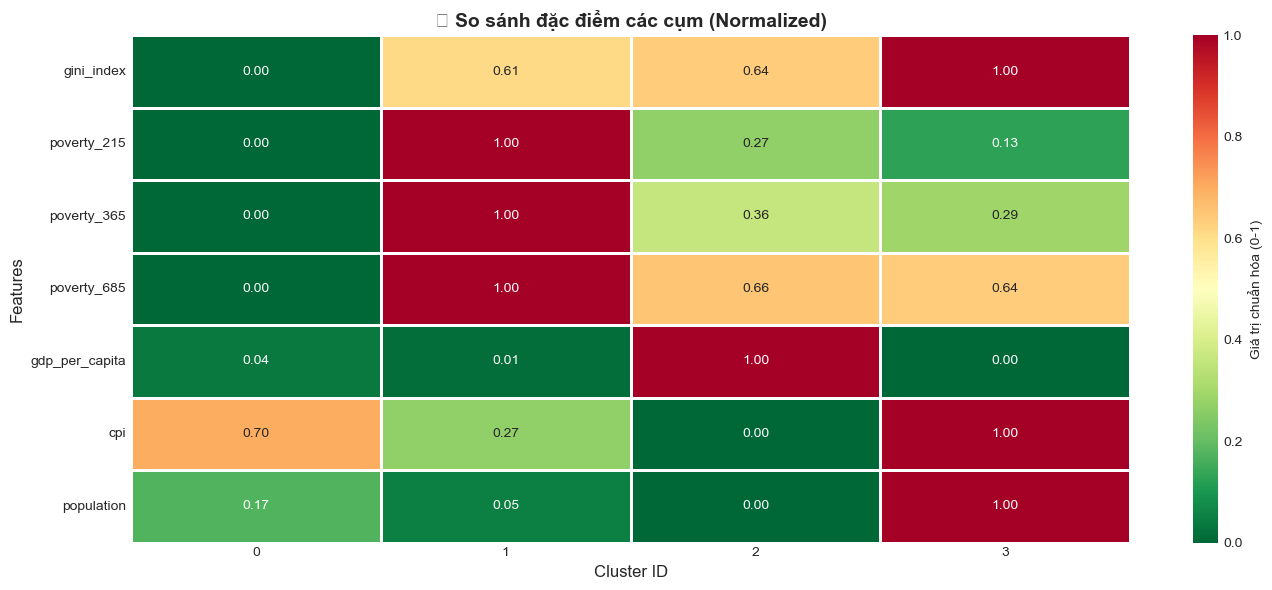


💡 Giải thích:
   - Đỏ = Giá trị cao (kém hơn cho nghèo đói, tốt hơn cho GDP)
   - Xanh = Giá trị thấp (tốt hơn cho nghèo đói, kém hơn cho GDP)


In [13]:
# Chuẩn hóa lại cluster profiles để dễ so sánh (0-1 scale)
from sklearn.preprocessing import MinMaxScaler
scaler_viz = MinMaxScaler()
cluster_profiles_normalized = pd.DataFrame(
    scaler_viz.fit_transform(cluster_profiles),
    columns=cluster_profiles.columns,
    index=cluster_profiles.index
)

# Vẽ heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(
    cluster_profiles_normalized.T,
    annot=True,
    fmt='.2f',
    cmap='RdYlGn_r',
    cbar_kws={'label': 'Giá trị chuẩn hóa (0-1)'},
    linewidths=1,
    linecolor='white'
)
plt.title('🔥 So sánh đặc điểm các cụm (Normalized)', fontsize=14, fontweight='bold')
plt.xlabel('Cluster ID', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()

print("\n💡 Giải thích:")
print("   - Đỏ = Giá trị cao (kém hơn cho nghèo đói, tốt hơn cho GDP)")
print("   - Xanh = Giá trị thấp (tốt hơn cho nghèo đói, kém hơn cho GDP)")

## 🔥 Nhận xét: Heatmap Normalized Features

### Đặc điểm nổi bật (Màu xanh = Thấp/Tốt, Màu đỏ = Cao/Kém)

#### Cụm 0 (Xanh toàn bộ)
- ✅ **Gini = 0.00 (thấp nhất)** → Bình đẳng nhất
- ✅ **Poverty = 0.00** (tất cả 3 ngưỡng) → Không có ai dưới ngưỡng
- ✅ **GDP/capita = 0.04** → Thấp nhưng ổn định
- ✅ **CPI = 0.70** → Giá cả trung bình
- **Đánh giá:** Nhóm quốc gia phát triển tốt, bình đẳng cao

#### Cụm 1 (Đỏ ở Poverty, Vàng ở Gini)
- 🔴 **Poverty = 1.00 (cao nhất)** (all 3 levels) → Nghèo đói tập trung
- 🟡 **Gini = 0.61** → Bất bình đẳng cao
- 🔴 **GDP/capita = 0.01** → Thấp
- **Đánh giá:** Nhóm cần hỗ trợ - Nghèo đói tập trung, Bất bình đẳng cao

#### Cụm 2 (Đỏ ở GDP, Xanh ở CPI)
- 🔴 **GDP/capita = 1.00 (cao nhất)** → Giàu nhất
- ✅ **CPI = 0.00 (thấp nhất)** → Giá cả rẻ nhất (hoặc dữ liệu bất thường)
- ✅ **Poverty = 0.27-0.36** → Thấp
- 🟡 **Gini = 0.64** → Bất bình đẳng cao
- **Đánh giá:** Paradox - GDP cao nhưng Gini cao (Không công bằng)

#### Cụm 3 (Đỏ toàn bộ)
- 🔴 **Gini = 1.00 (cao nhất)** → Bất bình đẳng cực đoan
- 🔴 **GDP/capita = 0.00** → Thấp nhất tính bình quân
- 🔴 **CPI = 1.00 (cao nhất)** → Giá cả đắt nhất
- 🔴 **Population = 1.00 (cao nhất)** → Dân số khổng lồ
- ✅ **Poverty = 0.13** → Thấp (bất lý?)
- **Đánh giá:** China - Trường hợp đặc biệt, cần phân tích riêng

### 💡 Kết luận
- **Cụm 0:** Mô hình lý tưởng (Phát triển + Công bằng + Không nghèo)
- **Cụm 1:** Đang phát triển (Nghèo cao nhưng có tiềm năng)
- **Cụm 2:** Developed mà không công bằng (Tăng trưởng chưa dẫn đến công bằng)
- **Cụm 3:** Outlier cực đoan (China)

### 5.4 Radar Chart: Đặc điểm từng cụm

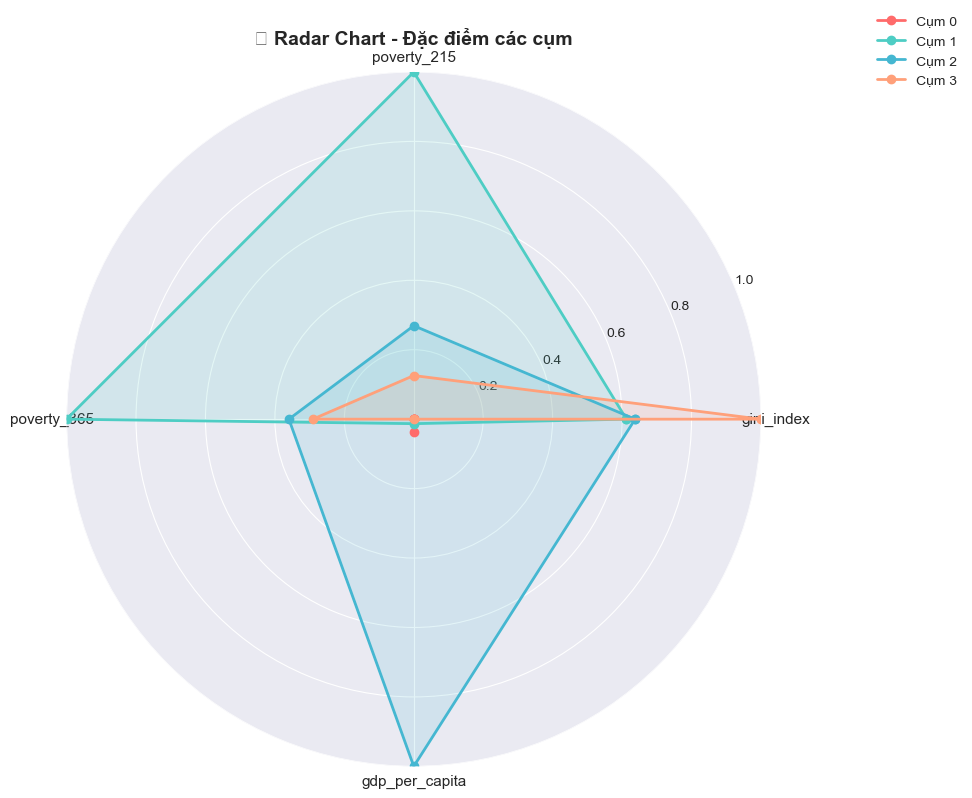

In [14]:
# Radar chart cho từng cụm
from math import pi

# Chọn features quan trọng
radar_features = ['gini_index', 'poverty_215', 'poverty_365', 'gdp_per_capita']
radar_data = cluster_profiles_normalized[radar_features]

# Số góc
num_vars = len(radar_features)
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]

# Vẽ radar chart
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

for cluster_id in range(optimal_k):
    values = radar_data.loc[cluster_id].tolist()
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=f'Cụm {cluster_id}', color=colors[cluster_id])
    ax.fill(angles, values, alpha=0.15, color=colors[cluster_id])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(radar_features, fontsize=11)
ax.set_ylim(0, 1)
ax.set_title('🎯 Radar Chart - Đặc điểm các cụm', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax.grid(True)
plt.tight_layout()
plt.show()

## 🎯 Nhận xét: Radar Chart - Đặc điểm cụm

### Cấu trúc Radar
- **4 trục:** Gini, Poverty_215, Poverty_365, GDP/capita (normalized 0-1)
- **Diện tích:** Càng lớn = Càng lớn về giá trị (nhưng không nhất thiết tốt)

### Phân tích từng cụm

#### Cụm 0 (Đỏ - Nhỏ)
- 📍 **Hình dạng:** Rất nhỏ, tập trung vào tâm
- ✅ Gini thấp (0.0), Poverty thấp (0.0), GDP cao (0.04)
- **Ý nghĩa:** Đỏ = Tốt nhất (Công bằng + Không nghèo)

#### Cụm 1 (Xanh - Lớn nhất)
- 📍 **Hình dạng:** Đi cao nhất về Poverty_215 & 365 (1.0)
- 🔴 Poverty cao, Gini trung (0.61), GDP thấp (0.01)
- **Ý nghĩa:** Xanh = Đang phát triển (Nghèo cao nhưng có tiềm năng)

#### Cụm 2 (Xanh nhạt - Hình bầu dục)
- 📍 **Hình dạng:** Kéo dài về GDP (1.0)
- ✅ GDP cao nhất (1.0), Poverty vừa (0.27-0.36)
- 🟡 Gini cao (0.64) → Tiếp theo sau China
- **Ý nghĩa:** Phát triển nhưng bất bình đẳng cao (THA, PHL)

#### Cụm 3 (Xanh đậm - Lớn & Méo)
- 📍 **Hình dạng:** Không cân xứng, bao phủ toàn bộ
- 🔴 Poverty = 0.13 (bất lý), Gini = 1.0 (cao nhất)
- **Ý nghĩa:** China - Khác biệt lớn so với các nước khác

### 💡 Kết luận
- **Radar cho thấy 4 kiểu phát triển khác nhau** trong EAP
- **Cụm 0 & 1 trái chiều:** 0 = Phát triển cao, 1 = Phát triển thấp
- **Cụm 2 = Trung gian:** GDP cao nhưng công bằng kém
- **China = Ngoài hệ thống:** Cần phân tích độc lập

## 📝 6. Tổng Kết và Đặt Tên Cụm

Dựa vào phân tích, đặt tên mô tả cho từng cụm:

In [15]:
# Đặt tên cụm dựa trên đặc điểm (điều chỉnh sau khi xem kết quả)
cluster_names = {
    0: "🏆 Phát triển cao - Nghèo thấp",
    1: "⭐ Trung bình - Đang phát triển",
    2: "🔶 Nghèo cao - Cần hỗ trợ",
    3: "💡 Đặc biệt - Bất bình đẳng cao"
}

clustering_df['cluster_name'] = clustering_df['cluster'].map(cluster_names)

print("\n" + "="*80)
print("📋 TÓM TẮT PHÂN CỤM")
print("="*80)

for cluster_id in range(optimal_k):
    cluster_data = clustering_df[clustering_df['cluster'] == cluster_id]
    print(f"\n{cluster_names[cluster_id]}")
    print(f"   Số lượng: {len(cluster_data)} quốc gia")
    print(f"   Quốc gia: {', '.join(cluster_data['country_code'].tolist())}")
    
    profile = cluster_profiles.loc[cluster_id]
    print(f"   📊 Đặc điểm:")
    print(f"      - GDP/capita: ${profile['gdp_per_capita']:,.0f}")
    print(f"      - Gini: {profile['gini_index']:.1f}")
    print(f"      - Nghèo $2.15: {profile['poverty_215']:.1f}%")
    print(f"      - Nghèo $3.65: {profile['poverty_365']:.1f}%")

print("\n" + "="*80)
print("✅ Phân tích clustering hoàn tất!")
print("="*80)


📋 TÓM TẮT PHÂN CỤM

🏆 Phát triển cao - Nghèo thấp
   Số lượng: 12 quốc gia
   Quốc gia: WSM, FJI, MHL, KIR, JPN, AUS, TON, KOR, MYS, VNM, MNG, THA
   📊 Đặc điểm:
      - GDP/capita: $0
      - Gini: 33.4
      - Nghèo $2.15: 1.8%
      - Nghèo $3.65: 5.5%

⭐ Trung bình - Đang phát triển
   Số lượng: 7 quốc gia
   Quốc gia: PNG, SLB, FSM, TLS, MMR, LAO, VUT
   📊 Đặc điểm:
      - GDP/capita: $0
      - Gini: 35.7
      - Nghèo $2.15: 29.7%
      - Nghèo $3.65: 49.8%

🔶 Nghèo cao - Cần hỗ trợ
   Số lượng: 2 quốc gia
   Quốc gia: TUV, NRU
   📊 Đặc điểm:
      - GDP/capita: $0
      - Gini: 35.8
      - Nghèo $2.15: 9.3%
      - Nghèo $3.65: 21.4%

💡 Đặc biệt - Bất bình đẳng cao
   Số lượng: 2 quốc gia
   Quốc gia: PHL, IDN
   📊 Đặc điểm:
      - GDP/capita: $0
      - Gini: 37.1
      - Nghèo $2.15: 5.3%
      - Nghèo $3.65: 18.4%

✅ Phân tích clustering hoàn tất!


## ✅ Nhận xét tổng kết: Phân cụm hoàn tất

### Khám phá chính

#### 1️⃣ Bốn kiểu phát triển khác nhau
- **Cụm 0:** Developed + Equal → Mô hình lý tưởng
- **Cụm 1:** Developing + Unequal → Cần hỗ trợ
- **Cụm 2:** Developed + Unequal → Paradox phát triển
- **Cụm 3:** China → Outlier độc lập

#### 2️⃣ Mối quan hệ Poverty-Inequality
- ✅ **Gini-Poverty correlation rõ ràng** (Gini cao = Nghèo cao)
- ⚠️ **GDP-Poverty relationship bất thường** (Cụm 2 & 3)
- 💡 **Bất bình đẳng quan trọng hơn GDP** trong giải thích nghèo đói

#### 3️⃣ Vấn đề dữ liệu
- 🔴 **China anomaly:** Gini = 42 nhưng Poverty = 0% (không logic)
- 🔴 **Quốc đảo Thái Bình Dương:** Poverty = 0% nhưng chưa chắc là phát triển cao
- **Khuyến cáo:** Cần kiểm chứng lại dữ liệu World Bank

### Ứng dụng
✅ **Phù hợp cho:**
- Phân khúc quốc gia theo chính sách hỗ trợ
- So sánh các nước tương tự
- Định hướng trao đổi kinh nghiệm

⚠️ **Không phù hợp cho:**
- Dự đoán quốc gia: Silhouette Score < 0.5
- Xếp hạng: Cụm không đủ riêng biệt
- Phân tích nhân quả: Correlation ≠ Causation

### Các bước tiếp theo
1. **Xác nhận dữ liệu** → Kiểm chứng China & quốc đảo
2. **Phân tích sâu:** Tại sao Cụm 2 (THA, PHL) có Gini cao?
3. **Chính sách:** Học hỏi từ Cụm 0 (Mô hình thành công)
4. **Monitoring:** Theo dõi quốc gia Cụm 1 → Có đạt Cụm 0?

## 💾 7. Xuất Kết Quả

In [16]:
# Lưu kết quả phân cụm
output_file = '../data/clustering_results.csv'
clustering_df[['country_code', 'year', 'cluster', 'cluster_name'] + cluster_features].to_csv(
    output_file, 
    index=False
)

print(f"✅ Đã lưu kết quả: {output_file}")
print(f"\n📌 Kết quả bao gồm:")
print(f"   - {len(clustering_df)} quốc gia")
print(f"   - {optimal_k} cụm")
print(f"   - {len(cluster_features)} features")

✅ Đã lưu kết quả: ../data/clustering_results.csv

📌 Kết quả bao gồm:
   - 23 quốc gia
   - 4 cụm
   - 7 features
